<left><img width=25% src="../source/logo.png"></left>

### Applied Machine Learning

## Mehmet Can Yavuz, PhD

Adapted from Volodymyr Kuleshov, Cornell Tech

# Lecture 7: Gaussian Discriminant Analysis

# 7.1. Revisiting Generative Models

In the last lecture, we introduced generative modeling and Naive Bayes. In this lecture, we will see more examples of generative models, namely Gaussian Discriminant Analysis.

Let's first review generative models and their distinction from discriminative models through a simple classification problem.


## 7.1.1. The Iris Flowers Dataset

As a motivating problem for this lecture, we are going to use the Iris flower dataset ([R. A. Fisher, 1936](https://en.wikipedia.org/wiki/Ronald_Fisher)). Recall that our task is to classify subspecies of Iris flowers based on their measurements. 

First, let’s load the dataset and print the examples from the dataset.

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris(as_frame=True)

# print part of the dataset
iris_X, iris_y = iris.data, iris.target
pd.concat([iris_X, iris_y], axis=1).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


If we only consider the first two feature columns, we can visualize the dataset in 2D.

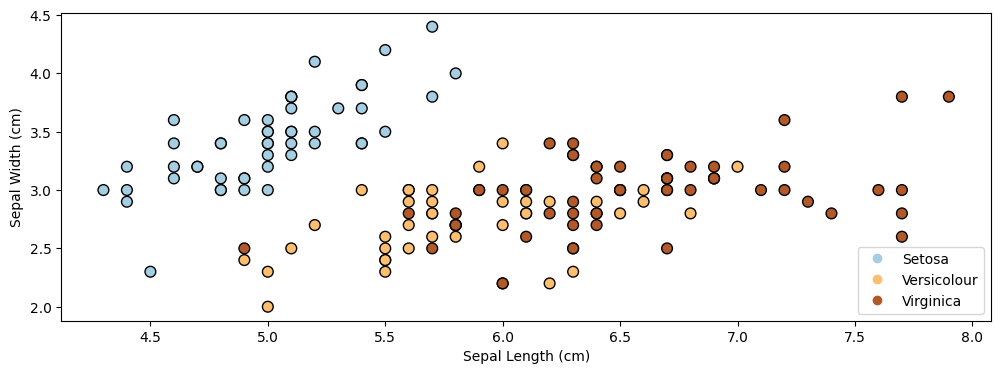

In [2]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

# create 2d version of dataset
X = iris_X.to_numpy()[:,:2]
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# Plot also the training points
p1 = plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolor='k', s=60, cmap=plt.cm.Paired)
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Versicolour', 'Virginica'], loc='lower right')

## 7.1.2. Review: Discriminative Models

Most models we have seen so far have been *discriminative*: 

* They directly transforms $x$ into a score for each class $y$ (e.g., via the formula $y=\sigma(\theta^\top x)$)

* They can be interpreted as defining a *conditional* probability $P_\theta(y|x)$

For example, logistic regression is a binary classification algorithm which uses a model 
$$f_\theta : \mathcal{X} \to [0,1]$$ 
of the form
$$ f_\theta(x) = \sigma(\theta^\top x) = \frac{1}{1 + \exp(-\theta^\top x)}, $$
where $\sigma(z) = \frac{1}{1 + \exp(-z)}$ is the *sigmoid* or *logistic* function.

The logistic model defines ("parameterizes") a probability distribution $P_\theta(y|x) : \mathcal{X} \times \mathcal{Y} \to [0,1]$ as follows:

\begin{align*}
P_\theta(y=1 | x) & = \sigma(\theta^\top x) \\
P_\theta(y=0 | x) & = 1-\sigma(\theta^\top x).
\end{align*}

Logistic regression optimizes the following objective defined over a binary classification dataset  $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.
\begin{align*}
\ell(\theta) & = \frac{1}{n}\sum_{i=1}^n \log P_\theta (y^{(i)} \mid x^{(i)}) \\
& = \frac{1}{n}\sum_{i=1}^n {y^{(i)}} \cdot \log \sigma(\theta^\top x^{(i)}) + (1-y^{(i)}) \cdot \log (1-\sigma(\theta^\top x^{(i)})).
\end{align*}

This objective is also often called the log-loss, or cross-entropy. This asks the model to output a large score $\sigma(\theta^\top x^{(i)})$ (a score that's close to one) if $y^{(i)}=1$, and a score that's small (close to zero) if $y^{(i)}=0$.

Now, let's train logistic/softmax regression on this dataset.

In [3]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)

# Create an instance of Logistic Regression Classifier and fit the data.
X = iris_X.to_numpy()[:,:2]
# rename class two to class one
Y = iris_y.copy()
logreg.fit(X, Y) 

LogisticRegression(C=100000.0)

We visualize the regions predicted to be associated with the blue, brown, and yellow classes and the lines between them are the decision boundaries.

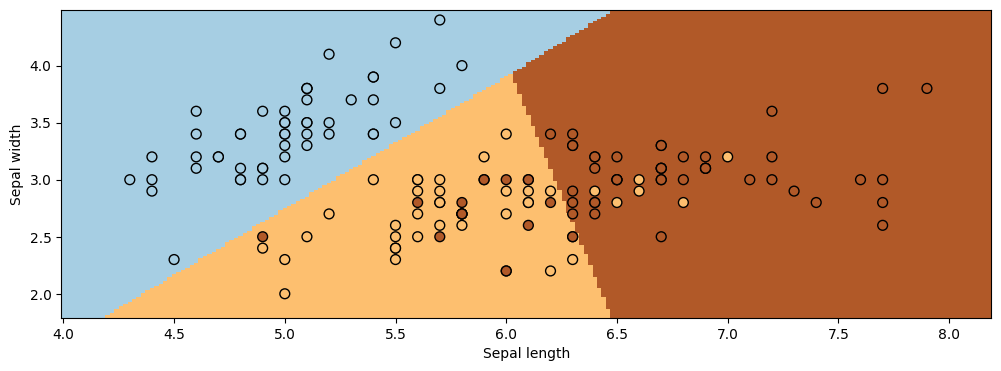

In [4]:
xx, yy = np.meshgrid(np.arange(4, 8.2, .02), np.arange(1.8, 4.5, .02))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired, s=50)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

## 7.1.3. Review: Generative Models

Another approach to classification is to use *generative* models.

* A generative approach first builds a model of $x$ for each class:
$$ P_\theta(x | y=k) \; \text{for each class $k$}.$$
$P_\theta(x | y=k)$ *scores* each $x$ according to how well it matches class $k$.

* A class probability $P_\theta(y=k)$ encoding our prior beliefs
$$ P_\theta(y=k) \; \text{for each class $k$}.$$
These are often just the % of each class in the data.

In the context of Iris flower classification, we would fit three models on a labeled corpus:

\begin{align*}
P_\theta(x|y=\text{0}) && P_\theta(x|y=\text{1}) && P_\theta(x|y=\text{2})
\end{align*}

We would also define priors $P_\theta(y=\text{0}), P_\theta(y=\text{1}),P_\theta(y=\text{2})$.

$P_\theta(x | y=k)$ *scores* each $x$ based on how much it looks like class $k$.

### 7.1.3.1. Probabilistic Interpretations

A *generative* model defines $P_\theta(x|y)$ and $P_\theta(y)$, thus it also defines a distribution of the form $P_\theta(x,y)$.

\begin{align*}
\underbrace{P_\theta(x,y) : \mathcal{X} \times \mathcal{Y} \to [0,1]}_\text{generative model} & \;\; & \underbrace{P_\theta(y|x) : \mathcal{X} \times \mathcal{Y} \to [0,1]}_\text{discriminative model}
\end{align*}

Discriminative models don't define any probability over the $x$'s. Generative models do.

We can learn a generative model $P_\theta(x, y)$ by maximizing the *likelihood*:

$$ \max_\theta \frac{1}{n}\sum_{i=1}^n \log P_\theta({x}^{(i)}, y^{(i)}). $$

This says that we should choose parameters $\theta$ such that the model $P_\theta$ assigns a high probability to each training example $(x^{(i)}, y^{(i)})$ in the dataset $\mathcal{D}$.

# 7.2. Gaussian Mixture Models

Next, we will define another generative model: Gaussian mixtures.

## 7.2.1. Review and Motivation 

### 7.2.1.1. Review of Distributions
#### Categorical Distribution

A [Categorical](https://en.wikipedia.org/wiki/Categorical_distribution) distribution with parameters $\theta$ is a probability
over $K$ discrete outcomes $x \in \{1,2,...,K\}$:

$$
P_\theta(x = j) = \theta_j.
$$

When $K=2$ this is called the [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution).
####  Normal (Gaussian) Distribution

A [multivariate normal](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) distribution $P_\theta(x) : \mathcal{X} \to [0,1]$ with parameters $\theta = (\mu, \Sigma)$
is a probability over a $d$-dimensional $x \in \mathbb{R}^d$

$$
P_\theta(x; \mu, \Sigma) = \frac{1}{\sqrt{(2 \pi)^d | \Sigma |}} \exp\left(-\frac{1}{2} (x - \mu)^\top \Sigma^{-1} (x-\mu) \right)
$$

In one dimension, this reduces to $\frac{1}{\sqrt{2 \pi}\sigma} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2} \right)$.

### 7.2.1.2. A Generative Model for Iris Flowers

To define a generative model for Iris flowers, we need to define three probabilities:
\begin{align*}
P_\theta(x|y=\text{0}) && P_\theta(x|y=\text{1}) && P_\theta(x|y=\text{2})
\end{align*}
We also define priors $P_\theta(y=\text{0}), P_\theta(y=\text{1}), P_\theta(y=\text{2})$.

Each model $P_\theta(x | y=k)$ *scores* $x$ based on how much it looks like class $k$.
The inputs $x$ are vectors of features for the flowers.
How do we choose $P_\theta(x|y=k)$?

This what the density of a Normal distribution looks like in 2D:

<center><img width=70% src="img/multivariate_gaussian1.png"></center>

This is how we can visualize it in a 2D plane:

<center><img width=70% src="img/multivariate_gaussian2.png"></center>

## 7.2.2. Gaussian Mixture Model

A *Gaussian mixture* model (GMM) $P_\theta(x,y)$ is defined for *real-valued data* $x \in \mathbb{R}^d$.

The $\theta$ contains prior parameters $\vec\phi = (\phi_1,...,\phi_K)$ and $K$ sets of per-class Gaussian parameters $\mu_k, \Sigma_k$.

The probability of the data $x$ for each class is a multivariate Gaussian
$$P_\theta(x|y=k) = \mathcal{N}(x ; \mu_k, \Sigma_k).$$

The probability over $y$ is Categorical:
$P_\theta(y=k) = \phi_k$.

### 7.2.2.1. Why Mixtures of Distributions?

A single distribution (e.g., a Gaussian) can be too simple to fit the data. We can form more complex distributions by *mixing* $K$ simple ones:

$$ P_\theta(x) = \phi_1 P_1(x ;\theta_1) + \phi_2 P_2(x ;\theta_2) + \ldots + \phi_1 P_K(x ;\theta_K) $$

where the $\phi_k \in [0,1]$ are the weights of each distribution.

A mixture of $K$ Gaussians is a distribution $P(x)$ of the form:
$$\phi_1 \mathcal{N}(x; \mu_1, \Sigma_1) + \phi_2 \mathcal{N}(x; \mu_2, \Sigma_2) + \ldots + \phi_K \mathcal{N}(x; \mu_K, \Sigma_K).$$

Mixtures can express distributions that a single mixture component can't:

<center><img width=65% src="img/mogdensity1d_v2.png"></center>

Here, we have a mixture of 3 Gaussians.

We can also represent a mixture of distributions by introducing $y \in \{1,2,...,K\}$ and a distribution over $(x,y)$ of the form
$$ P_\theta(x,y) = P_\theta(x|y) P_\theta(y)$$
that has two components:

* The distribution $P_\theta(y=k) = \pi_k$ encodes the mixture weights.

* The distribution $P_\theta(x|y=k) = P_k(x; \theta_k)$ encodes the $k$-th mixed distribution.

This is a mixture of distributions because:
\begin{align*}
P_\theta(x) & = \sum_{k=1}^K P_\theta(x|y=k)P_\theta(y=k) \\
& = \pi_1 P_1(x ;\theta_1) + \pi_2 P_2(x ;\theta_2) + \ldots + \pi_1 P_K(x ;\theta_K)
\end{align*}

### 7.2.2.2. GMMs Are Indeed Mixtures

The Gaussian Mixture Model is an example of a mixture of $K$ distributions with mixing weights $\phi_k = P(y=k)$:
$$P_\theta(x) = \sum_{k=1}^K P_\theta(y=k) P_\theta(x|y=k) = \sum_{k=1}^K \phi_k \mathcal{N}(x; \mu_k, \Sigma_k)$$

Intuitively, this model defines a story for how the data was generated. To obtain a data point,

* First, we sample a class $y \sim \text{Categorical}(\phi_1, \phi_2, ..., \phi_K)$ with class proportions given by the $\phi_k$.

* Then, we sample an $x$ from a Gaussian distribution $\mathcal{N}(\mu_k, \Sigma_k)$ specific to that class.

Such a story can be constructed for most generative algorithms and helps understand them.

Mixtures of Gaussians fit more complex distributions than one Gaussian.

The figures below illustrate how the mixture of two Gaussians can model the distribution composed of two separate clusters, which are poorly represented by a single Gaussian. 

Raw data | Single Gaussian | Mixture of Gaussians
--|--|---
<img width=90% src="img/oldfaithful_v2.png"> | <img width=90% src="img/oldfSingle_v2.png"> | <img width=90% src="img/oldfMOG_v2.png">

### 7.2.2.3. Predictions Out of Gaussian Mixture Models

Given a trained model $P_\theta (x,z) = P_\theta (x | z) P_\theta (z)$, we can look at the *posterior* probability
$$P_\theta(z = k\mid x) = \frac{P_\theta(z=k, x)}{P_\theta(x)} = \frac{P_\theta(x | z=k) P_\theta(z=k)}{\sum_{l=1}^K P_\theta(x | z=l) P_\theta(z=l)}$$
of a point $x$ belonging to class $k$.

# 7.3. Gaussian Discriminant Analysis

Next, we will use GMMs as the basis for a new generative classification algorithm, Gaussian Discriminant Analysis (GDA).

## 7.3.1. Review: Maximum Likelihood Learning

We can learn a generative model $P_\theta(x, y)$ by maximizing the *maximum likelihood*:

$$ \max_\theta \frac{1}{n}\sum_{i=1}^n \log P_\theta({x}^{(i)}, y^{(i)}). $$

This seeks to find parameters $\theta$ such that the model assigns high probability to the training data.

Let's use maximum likelihood to fit the Gaussian Discriminant model. Note that model parameters $\theta$ are the union of the parameters of each sub-model:
$$\theta = (\mu_1, \Sigma_1, \phi_1, \ldots, \mu_K, \Sigma_K, \phi_K).$$


Mathematically, the components of the model $P_\theta(x,y)$ are as follows.
\begin{align*}
P_\theta(y) & = \frac{\prod_{k=1}^K \phi_k^{\mathbb{I}\{y = y_k\}}}{\sum_{k=1}^k \phi_k} \\
P_\theta(x|y=k) & = \frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}} \exp(-\frac{1}{2}(x-\mu_k)^\top\Sigma_k^{-1}(x-\mu_k))
\end{align*}

## 7.3.2. Optimizing the Log Likelihood

Given a dataset $\mathcal{D} = \{(x^{(i)}, y^{(i)})\mid i=1,2,\ldots,n\}$, we want to optimize the log-likelihood $\ell(\theta)$:
\begin{align*}
\ell(\theta) & = \sum_{i=1}^n \log P_\theta(x^{(i)}, y^{(i)}) = \sum_{i=1}^n \log P_\theta(x^{(i)} | y^{(i)}) + \sum_{i=1}^n \log P_\theta(y^{(i)}) \\
& = \sum_{k=1}^K  \underbrace{\sum_{i : y^{(i)} = k} \log P(x^{(i)} | y^{(i)} ; \mu_k, \Sigma_k)}_\text{all the terms that involve $\mu_k, \Sigma_k$} + \underbrace{\sum_{i=1}^n \log P(y^{(i)} ; \vec \phi)}_\text{all the terms that involve $\vec \phi$}.
\end{align*}

In equality #2, we use the fact that $P_\theta(x,y)=P_\theta(y) P_\theta(x|y)$; in the third one, we change the order of summation.

Each $\mu_k, \Sigma_k$ for $k=1,2,\ldots,K$ is found in only the following terms:
\begin{align*}
\max_{\mu_k, \Sigma_k} \sum_{i=1}^n \log P_\theta(x^{(i)}, y^{(i)})
& = \max_{\mu_k, \Sigma_k} \sum_{l=1}^K  \sum_{i : y^{(i)} = l} \log P_\theta(x^{(i)} | y^{(i)} ; \mu_l, \Sigma_l) \\
& = \max_{\mu_k, \Sigma_k} \sum_{i : y^{(i)} = k} \log P_\theta(x^{(i)} | y^{(i)} ; \mu_k, \Sigma_k).
\end{align*}
Thus, optimization over $\mu_k, \Sigma_k$ can be carried out independently of all the other parameters by just looking at these terms.

Similarly, optimizing for $\vec \phi = (\phi_1, \phi_2, \ldots, \phi_K)$ only involves a few terms:
$$ \max_{\vec \phi} \sum_{i=1}^n \log P_\theta(x^{(i)}, y^{(i)} ; \theta) = \max_{\vec\phi} \
\sum_{i=1}^n  \log P_\theta(y^{(i)} ; \vec \phi). $$

### 7.3.2.1. Learning the Parameters $\phi$

Let's first consider the optimization over $\vec \phi = (\phi_1, \phi_2, \ldots, \phi_K)$. 
$$ \max_{\vec \phi} \sum_{i=1}^n  \log P_\theta(y=y^{(i)} ; \vec \phi). $$
* We have $n$ datapoints. Each point has a label $k\in\{1,2,...,K\}$.

* Our model is a categorical and assigns a probability $\phi_k$ to each outcome $k\in\{1,2,...,K\}$.

* We want to infer $\phi_k$ assuming our dataset is sampled from the model.

What are the maximum likelihood $\phi_k$ that are most likely to have generated our data? 
Intuitively, the maximum likelihood class probabilities $\phi$ should just be the class proportions that we see in the data. 


Let's calculate this formally. Our objective $J(\vec \phi)$ equals
\begin{align*}
J(\vec\phi) & = \sum_{i=1}^n  \log P_\theta(y^{(i)} ; \vec \phi) \\
& = \sum_{i=1}^n \log \phi_{y^{(i)}} - n \cdot \log \sum_{k=1}^K \phi_k \\ 
& = \sum_{k=1}^K \sum_{i : y^{(i)} = k} \log \phi_k - n \cdot \log \sum_{k=1}^K \phi_k
\end{align*}

Taking the partial derivative with respect to $\phi_k$:
\begin{align*}
\frac{\partial}{\partial_{\phi_k}} J(\vec\phi) 
& = \frac{\partial}{\partial_{\phi_k}} \left (\sum_{l=1}^K \sum_{i : y^{(i)} = l} \log \phi_l - n \cdot \log \sum_{l=1}^K \phi_l \right) \\
& = \frac{\partial}{\partial_{\phi_k}} \sum_{i : y^{(i)} = k} \log \phi_k - \frac{\partial}{\partial_{\phi_k}} n \cdot \log \sum_{l=1}^K \phi_l \\
& = n_k \cdot \frac{\partial}{\partial_{\phi_k}} \log \phi_k - n \cdot \frac{\partial}{\partial_{\phi_k}}  \log \sum_{l=1}^K \phi_l \\
& =  \frac{n_k}{\phi_k} - \frac{n}{\sum_{l=1}^K \phi_l}
\end{align*}

Setting this derivative to zero, we obtain 
$$ \frac{\phi_k}{\sum_l \phi_l} = \frac{n_k}{n}$$
for each $k$, where $n_k = |\{i : y^{(i)} = k\}|$ is the number of training targets with class $k$. Thus, the optimal $\phi_k$ is just the proportion of data points with class $k$ in the training set!



### 7.3.2.2. Learning the Parameters $\mu_k, \Sigma_k$

Next, let's look at the maximum likelihood term
$$\max_{\mu_k, \Sigma_k} \sum_{i : y^{(i)} = k} \log \mathcal{N}(x^{(i)} | \mu_k, \Sigma_k)$$
over the Gaussian parameters $\mu_k, \Sigma_k$.

* Our dataset are all the points $x$ for which $y=k$.

* We want to learn the mean and variance $\mu_k, \Sigma_k$ of a normal distribution that generates this data.

What is the maximum likelihood $\mu_k, \Sigma_k$ in this case?

Computing the derivative and setting it to zero, we obtain closed form solutions:
\begin{align*}
\mu_k & = \frac{\sum_{i: y^{(i)} = k} x^{(i)}}{n_k} \\
\Sigma_k & = \frac{\sum_{i: y^{(i)} = k} (x^{(i)} - \mu_k)(x^{(i)} - \mu_k)^\top}{n_k} \\
\end{align*}
These are just the empirical means and covariances of each class.

### 7.3.2.3. Querying the Model

How do we ask the model for predictions? As discussed earlier, we can apply Bayes' rule:
$$\arg\max_y P_\theta(y|x) = \arg\max_y P_\theta(x|y)P(y).$$
Thus, we can estimate the probability of $x$ and under each $P_\theta(x|y=k)P(y=k)$ and choose the class that explains the data best.

## 7.3.3. Algorithm: Gaussian Discriminant Analysis (GDA)

The above procedure describes an example of generative models---Gaussian Discriminant Analysis (GDA). We can succinctly define GDA in terms of the algorithm components.

* __Type__: Supervised learning (multi-class classification)

* __Model family__: Mixtures of Gaussians.

* __Objective function__: Log-likelihood.

* __Optimizer__: Closed form solution.

### 7.3.3.1. Example: Iris Flower Classification

Let's see how this approach can be used in practice on the Iris dataset.

* We will learn the maximum likelihood GDA parameters

* We will compare the outputs to the true predictions.

Let's first start by computing the true parameters on our dataset.

In [5]:
# we can implement these formulas over the Iris dataset
d = 2 # number of features in our toy dataset
K = 3 # number of classes
n = X.shape[0] # size of the dataset

# these are the shapes of the parameters
mus = np.zeros([K,d])
Sigmas = np.zeros([K,d,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(3):
    X_k = X[iris_y == k]
    mus[k] = np.mean(X_k, axis=0)
    Sigmas[k] = np.cov(X_k.T)
    phis[k] = X_k.shape[0] / float(n)

# print out the means
print(mus)

[[5.006 3.428]
 [5.936 2.77 ]
 [6.588 2.974]]


We can compute predictions using Bayes' rule.

In [6]:
# we can implement this in numpy
def gda_predictions(x, mus, Sigmas, phis):
    """This returns class assignments and p(y|x) under the GDA model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x, (1, n, d, 1))
    mus = np.reshape(mus, (K, 1, d, 1))
    Sigmas = np.reshape(Sigmas, (K, 1, d, d))    
    
    # compute probabilities
    py = np.tile(phis.reshape((K,1)), (1,n)).reshape([K,n,1,1])
    pxy = (
        np.sqrt(np.abs((2*np.pi)**d*np.linalg.det(Sigmas))).reshape((K,1,1,1)) 
        * -.5*np.exp(
            np.matmul(np.matmul((x-mus).transpose([0,1,3,2]), np.linalg.inv(Sigmas)), x-mus)
        )
    )
    pyx = pxy * py
    return pyx.argmax(axis=0).flatten(), pyx.reshape([K,n])

idx, pyx = gda_predictions(X, mus, Sigmas, phis)
print(idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1
 2 2 2 2 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 2 2 1 2 2 2 2 2
 2 1]


We visualize the decision boundaries like we did earlier. The figure illustrates that three Gaussians learned through Gaussian Discriminant Analysis split the data points from three classes reasonably.

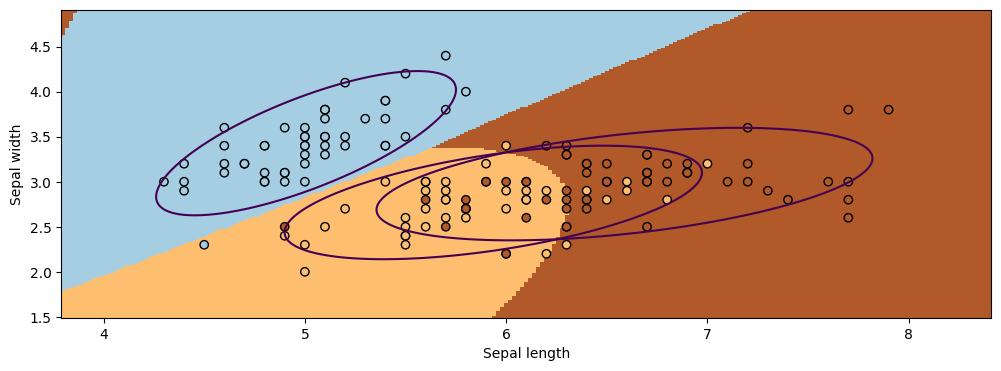

In [7]:
from matplotlib.colors import LogNorm
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z, pyx = gda_predictions(np.c_[xx.ravel(), yy.ravel()], mus, Sigmas, phis)
logpy = np.log(-1./3*pyx)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
contours = np.zeros([K, xx.shape[0], xx.shape[1]])
for k in range(K):
    contours[k] = logpy[k].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
for k in range(K):
    plt.contour(xx, yy, contours[k], levels=np.logspace(0, 1, 1))

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

### 7.3.3.2. Special Cases of GDA

Many important generative algorithms are special cases of Gaussian Discriminative Analysis

* Linear discriminant analysis (LDA): all the covariance matrices $\Sigma_k$ take the same value.

* Gaussian Naive Bayes: all the covariance matrices $\Sigma_k$ are diagonal.

* Quadratic discriminant analysis (QDA): another term for GDA.

# 7.4. Discriminative vs. Generative Algorithms

We conclude our lectures on generative algorithms by revisiting the question of how they compare to discriminative algorithms.

## 7.4.1. Linear Discriminant Analysis

When the covariances $\Sigma_k$ in GDA are equal, we have an algorithm called Linear Discriminant Analysis or LDA.

The probability of the data $x$ for each class is a multivariate Gaussian with the same covariance $\Sigma$.
$$P_\theta(x|y=k) = \mathcal{N}(x ; \mu_k, \Sigma).$$

The probability over $y$ is Categorical:
$P_\theta(y=k) = \phi_k$.

Let's try this algorithm on the Iris flower dataset.

We compute the model parameters similarly to how we did for GDA.

In [8]:
# we can implement these formulas over the Iris dataset
d = 2 # number of features in our toy dataset
K = 3 # number of clases
n = X.shape[0] # size of the dataset

# these are the shapes of the parameters
mus = np.zeros([K,d])
Sigmas = np.zeros([K,d,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(3):
    X_k = X[iris_y == k]
    mus[k] = np.mean(X_k, axis=0)
    Sigmas[k] = np.cov(X.T) # this is now X.T instead of X_k.T
    phis[k] = X_k.shape[0] / float(n)

# print out the means
print(mus)

[[5.006 3.428]
 [5.936 2.77 ]
 [6.588 2.974]]


We can compute predictions using Bayes' rule.

In [9]:
# we can implement this in numpy
def gda_predictions(x, mus, Sigmas, phis):
    """This returns class assignments and p(y|x) under the GDA model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x, (1, n, d, 1))
    mus = np.reshape(mus, (K, 1, d, 1))
    Sigmas = np.reshape(Sigmas, (K, 1, d, d))    
    
    # compute probabilities
    py = np.tile(phis.reshape((K,1)), (1,n)).reshape([K,n,1,1])
    pxy = (
        np.sqrt(np.abs((2*np.pi)**d*np.linalg.det(Sigmas))).reshape((K,1,1,1)) 
        * -.5*np.exp(
            np.matmul(np.matmul((x-mus).transpose([0,1,3,2]), np.linalg.inv(Sigmas)), x-mus)
        )
    )
    pyx = pxy * py
    return pyx.argmax(axis=0).flatten(), pyx.reshape([K,n])

idx, pyx = gda_predictions(X, mus, Sigmas, phis)
print(idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1
 2 2 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 1 2 2
 1 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


We visualize predictions like we did earlier. 

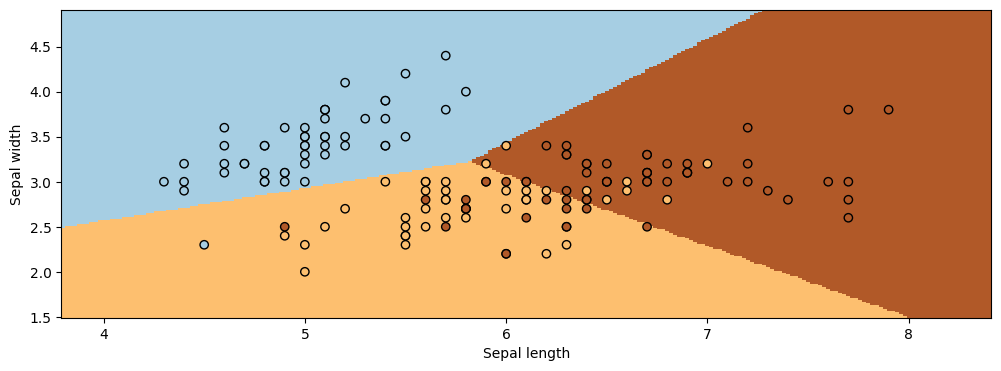

In [10]:
from matplotlib.colors import LogNorm
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z, pyx = gda_predictions(np.c_[xx.ravel(), yy.ravel()], mus, Sigmas, phis)
logpy = np.log(-1./3*pyx)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
contours = np.zeros([K, xx.shape[0], xx.shape[1]])
for k in range(K):
    contours[k] = logpy[k].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

Linear Discriminant Analysis outputs decision boundaries that are linear, just like Logistic/Softmax Regression.

Softmax or Logistic regression also produce linear boundaries. In fact, both types of algorithms make use of the same model class.

What is their difference then?

### 7.4.1.1.  What Is the LDA Model Class?

We can derive a formula for $P_\theta(y|x)$ in a Bernoulli Naive Bayes or LDA model when $K=2$:
$$ P_\theta(y|x) = \frac{P_\theta(x|y)P_\theta(y)}{\sum_{y'\in \mathcal{Y}}P_\theta(x|y')P_\theta(y')} = \frac{1}{1+\exp(-\gamma^\top x)} $$
for some set of parameters $\gamma$ (whose expression can be derived from $\theta$). 

This is the same form as Logistic Regression! Does it mean that the two sets of algorithms are equivalent? 

No! They assume the same model class $\mathcal{M}$, they use a different objective $J$ to select a model in $\mathcal{M}$.

### 7.4.1.2. LDA vs. Logistic Regression

We describe the procedure of LDA above, and here we summarize the differences between the generative model LDA and the discriminative models NB and logistic regression.

* Bernoulli Naive Bayes or LDA assumes a logistic form for $P(y|x)$. But the converse is not true: logistic regression does not assume a NB or LDA model for $P(x,y)$.

* Generative models make stronger modeling assumptions. If these assumptions hold true, the generative models will perform better.

* But if they don't, logistic regression will be more robust to outliers and model misspecification, and achieve higher accuracy.

## 7.4.2. Generative Models vs. Discriminative Models

Finally, we are revisiting the question of when we want to use generative models or discriminative models.

Discriminative algorithms are deservingly very popular. 

* Most state-of-the-art algorithms for classification are discriminative (including neural nets, boosting, SVMs, etc.)

* They are often more accurate because they make fewer modeling assumptions.

But generative models can do things that discriminative models can't do. 

* __Generation__: we can sample $x \sim p(x|y)$ to generate new data (images, audio).

* __Missing value imputation__: if $x_j$ is missing, we infer it using $p(x|y)$.

* __Outlier detection__: we may detect via $p(x')$ if $x'$ is an outlier.

* __Scalability__: Simple formulas for maximum likelihood parameters.

And generative algorithms also have many other advantages:

* Can do more than just prediction: generation, fill-in missing features, etc.

* Can include extra prior knowledge; if prior knowledge is correct, model will be more accurate.

* Often have closed-form solutions, hence are faster to train.